# Clustering de documents

[nltk_data] Downloading package punkt to /Users/ilaria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ilaria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


 999 documents chargés.
 TF-IDF shape : (999, 26084)

 Répartition des documents par cluster :
{0: ['KB_JB838_1951-03-23_01-00009.txt',
     'KB_JB838_1951-03-24_01-00009.txt',
     'KB_JB838_1951-03-31_01-00010.txt',
     'KB_JB838_1951-04-03_01-00008.txt',
     'KB_JB838_1951-06-16_01-00010.txt',
     'KB_JB838_1951-09-07_01-00009.txt',
     'KB_JB838_1951-10-03_01-00009.txt',
     'KB_JB838_1952-03-14_01-00014.txt',
     'KB_JB838_1952-03-15_01-00013.txt',
     'KB_JB838_1952-04-01_01-00010.txt',
     'KB_JB838_1952-04-02_01-00012.txt',
     'KB_JB838_1953-04-21_01-00012.txt',
     'KB_JB838_1954-02-06_01-00011.txt',
     'KB_JB838_1954-02-09_01-00010.txt',
     'KB_JB838_1954-02-10_01-00009.txt',
     'KB_JB838_1954-02-11_01-00010.txt',
     'KB_JB838_1954-02-27_01-00011.txt',
     'KB_JB838_1954-03-02_01-00009.txt',
     'KB_JB838_1954-03-11_01-00014.txt',
     'KB_JB838_1954-04-13_01-00011.txt',
     'KB_JB838_1954-04-14_01-00011.txt',
     'KB_JB838_1954-04-27_01-00009.txt',
   

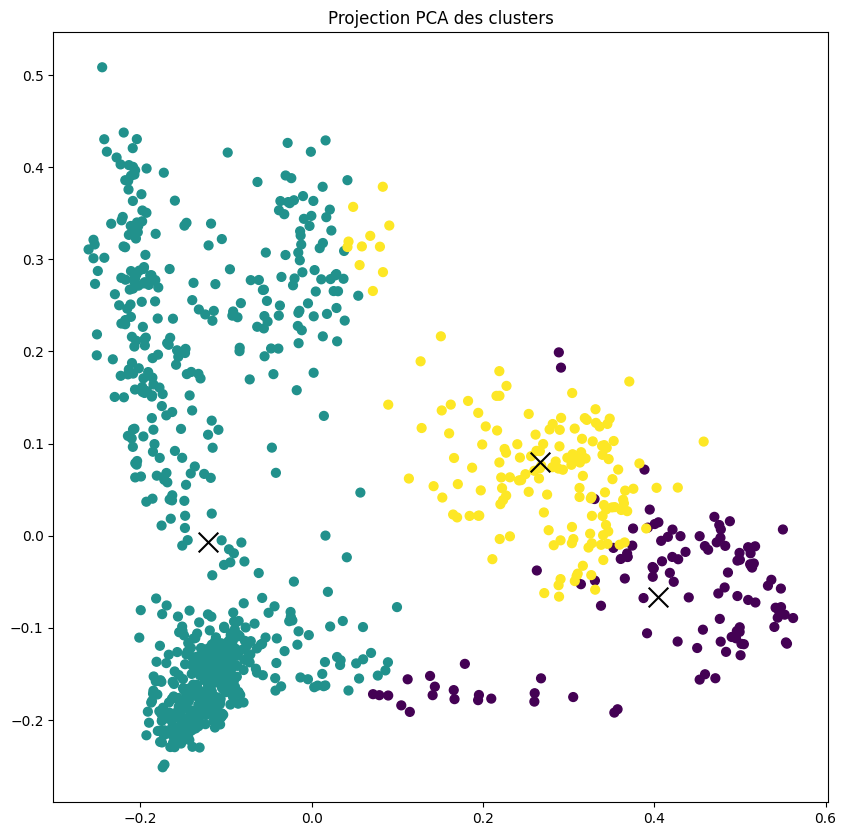

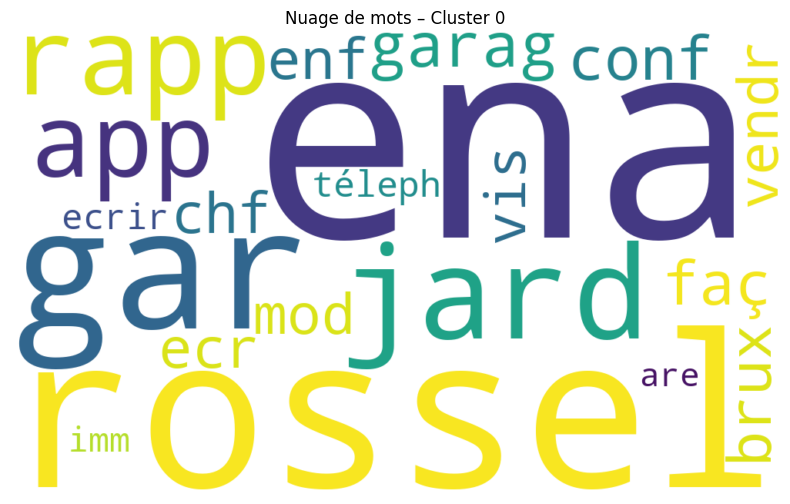

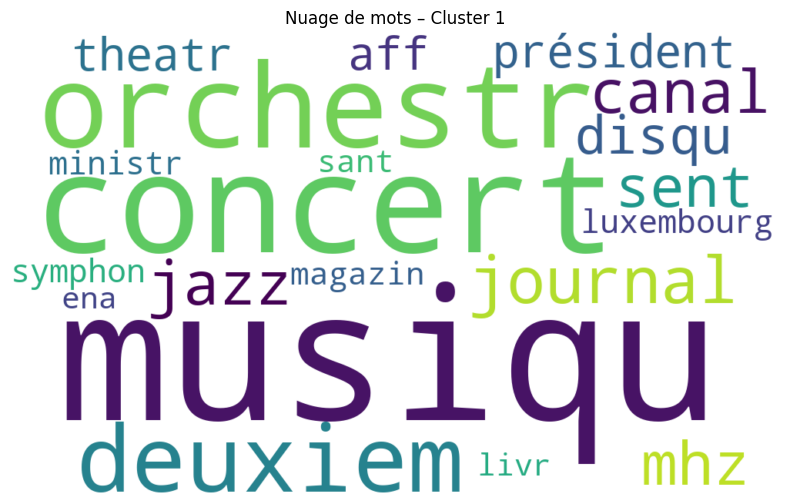

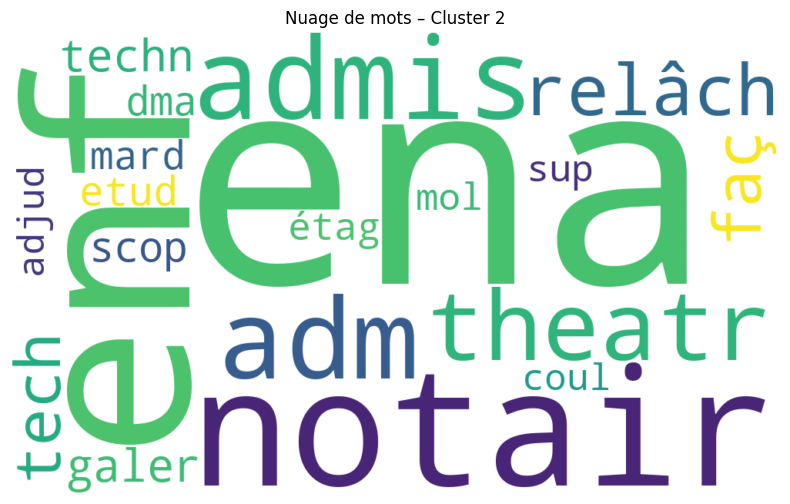

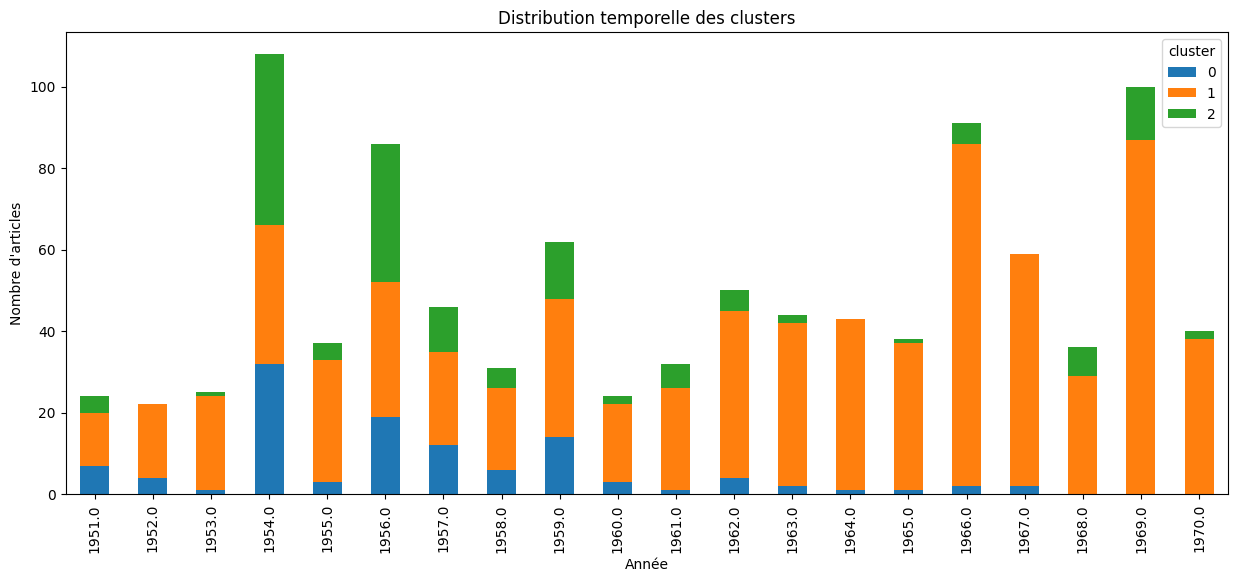


 Analyse exportée dans clustering_full_results.pkl


In [5]:
# ============================
# 1️ IMPORTS
# ============================

import os
import re
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import FrenchStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances

from wordcloud import WordCloud
import spacy
import pickle

nltk.download("punkt")
nltk.download("stopwords")


# ============================
# 2️ CHARGEMENT DU CORPUS COMPLET
# ============================

data_path = "../../data/txt_tp4/"
files = sorted([f for f in os.listdir(data_path) if f.endswith(".txt")])
texts = [open(os.path.join(data_path, f), "r", encoding="utf-8").read() for f in files]

print(f" {len(texts)} documents chargés.")


# ============================
# 3️ NETTOYAGE LINGUISTIQUE STANDARD
# ============================

stemmer = FrenchStemmer()
french_sw = stopwords.words("french")

def preprocess(text):
    text = text.lower()
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if len(t) > 2]
    tokens = [stemmer.stem(t) for t in tokens]
    return tokens


# ============================
# 4️ TF-IDF SUR TOUT LE CORPUS
# ============================

vectorizer = TfidfVectorizer(
    tokenizer=preprocess,
    stop_words=french_sw,
    min_df=5,
    max_df=0.6
)

tfidf_vectors = vectorizer.fit_transform(texts)
terms = vectorizer.get_feature_names_out()

print(" TF-IDF shape :", tfidf_vectors.shape)


# ============================
# 5️ CLUSTERING KMEANS (3 CLUSTERS)
# ============================

N_CLUSTERS = 3
km_model = KMeans(n_clusters=N_CLUSTERS, random_state=42)
clusters = km_model.fit_predict(tfidf_vectors)

clustering = collections.defaultdict(list)
for i, label in enumerate(clusters):
    clustering[label].append(files[i])

print("\n Répartition des documents par cluster :")
pprint(dict(clustering))


# ============================
# 6️ MOTS-CLÉS PAR CLUSTER
# ============================

centers = km_model.cluster_centers_
N_TOP = 20

cluster_keywords = {}

for i in range(N_CLUSTERS):
    idx = centers[i].argsort()[-N_TOP:][::-1]
    cluster_keywords[i] = [(terms[j], float(centers[i][j])) for j in idx]

print("\n Mots-clés par cluster :")
pprint(cluster_keywords)


# ============================
# 7️ DOCUMENTS REPRÉSENTATIFS
# ============================

tfidf_array = tfidf_vectors.toarray()
repr_docs = {}

for c in range(N_CLUSTERS):
    distances = cosine_distances(tfidf_array, centers[c].reshape(1, -1)).reshape(-1)
    closest = distances.argsort()[:5]
    repr_docs[c] = [files[i] for i in closest]

print("\n Documents représentatifs par cluster :")
pprint(repr_docs)


# ============================
# 8️ VISUALISATION PCA
# ============================

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_array)

plt.figure(figsize=(10,10))
plt.scatter(reduced_vectors[:,0], reduced_vectors[:,1], c=clusters, s=40)

centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:,0], centroids[:,1], marker="x", s=200, color="black")

plt.title("Projection PCA des clusters")
plt.show()


# ============================
# 9️ NUAGE DE MOTS PAR CLUSTER
# ============================

for c in range(N_CLUSTERS):
    freq = {w: s for w, s in cluster_keywords[c]}
    wc = WordCloud(width=1000, height=600, background_color="white").generate_from_frequencies(freq)

    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Nuage de mots – Cluster {c}")
    plt.show()


# ============================
# 10 ANALYSE TEMPORELLE
# ============================

years = []

for f in files:
    match = re.search(r"(\d{4})", f)
    years.append(int(match.group(1)) if match else None)

df_time = pd.DataFrame({
    "file": files,
    "cluster": clusters,
    "year": years
})

timeline = df_time.groupby(["cluster","year"]).size().unstack(fill_value=0)

timeline.T.plot(kind="bar", stacked=True, figsize=(15,6))
plt.title("Distribution temporelle des clusters")
plt.xlabel("Année")
plt.ylabel("Nombre d'articles")
plt.show()


# ============================
# 11 EXPORT FINAL
# ============================

data_export = {
    "clusters": clusters,
    "files": files,
    "keywords": cluster_keywords,
    "representative_docs": repr_docs,
    "timeline": timeline
}


with open("clustering_full_results.pkl", "wb") as f:
    pickle.dump(data_export, f)

print("\n Analyse exportée dans clustering_full_results.pkl")
